# Modules importation and data loading

In [417]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD# SVD = Singular Value Descomposition
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.feature_extraction import stop_words
from sklearn.base import TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score, accuracy_score
from sklearn.preprocessing import Normalizer, LabelBinarizer, OneHotEncoder
from sklearn.metrics import make_scorer

random_state=0

In [390]:
# Data loading
NROWS = sys.maxsize
#NROWS = 100
## Negative dataset
df_neg = pd.read_csv('./practica_clase/PRECISION_MEDICINE/negative_training_abstracts.tsv', sep='\t', 
                     header=None, nrows = NROWS)

df_neg.columns = ['Accession number', 'Title', 'Abstract']
df_neg['Label'] = '0' #'neg'

display(df_neg.head())

corpus_neg = list(df_neg['Abstract'].values)
### len(corpus_neg) # 4078

## Positive
df_pos = pd.read_csv('./practica_clase/PRECISION_MEDICINE/positive_training_abstracts.tsv', sep='\t', 
                     header=None, nrows = NROWS)

df_pos.columns = ['Accession number', 'Title', 'Abstract']
df_pos['Label'] = '1' # 'pos'
display(df_pos.head())

# Add corpus
df_corpus = df_neg.append(df_pos)
display(df_corpus.head())

# len(corpus) # 8156

labels = df_corpus['Label']
corpus = df_corpus['Abstract']
# len(labels) # 8156

print(len(corpus), len(labels))

,Accession number,Title,Abstract,Label
0,29606186,Can reactivity and regulation in infancy predi...,A need to identify early infant markers of lat...,0
1,29471205,"Fabrication of bioinspired, self-cleaning supe...","The mechanical properties, corrosion-resistanc...",0
2,29175165,Functional properties of chickpea protein isol...,"In the present study, the effect of Refractanc...",0
3,29098524,Mechanical dyssynchrony alters left ventricula...,The impact of left bundle branch block (LBBB) ...,0
4,27507285,Reducing the width of confidence intervals for...,"In the last decade, it has been shown that an ...",0


,Accession number,Title,Abstract,Label
0,27829177,A naturally occurring variant of HPV-16 E7 exe...,Human Papillomavirus E6 and E7 play critical r...,1
1,27806271,Functional Analysis of Orai1 Concatemers Suppo...,Store-operated Ca(2+) entry occurs through the...,1
2,27796307,KAT2A/KAT2B-targeted acetylome reveals a role ...,Lysine acetylation is a widespread post-transl...,1
3,27795438,The Cellular DNA Helicase ChlR1 Regulates Chro...,"In papillomavirus infections, the viral genome...",1
4,27794539,Human R1441C LRRK2 regulates the synaptic vesi...,Mutations in leucine-rich repeat kinase 2 (LRR...,1


,Accession number,Title,Abstract,Label
0,29606186,Can reactivity and regulation in infancy predi...,A need to identify early infant markers of lat...,0
1,29471205,"Fabrication of bioinspired, self-cleaning supe...","The mechanical properties, corrosion-resistanc...",0
2,29175165,Functional properties of chickpea protein isol...,"In the present study, the effect of Refractanc...",0
3,29098524,Mechanical dyssynchrony alters left ventricula...,The impact of left bundle branch block (LBBB) ...,0
4,27507285,Reducing the width of confidence intervals for...,"In the last decade, it has been shown that an ...",0


8156 8156


## Data split

In [391]:
TEST_SIZE = 0.33
X_train, X_test, y_train, y_test = train_test_split(
    corpus, labels, test_size=TEST_SIZE, random_state=random_state)

# Part I. Construction of an automatic classifier

The following parameters can be adjusted in order to try to maximize the quality of the
classifier:

- In function TfidfVectorizer:
    * Parameters that affect the vocabulary quality:
        * List of stopwords (one of the options is setting it to None)
        * maxfeatures
        * max_df, min_df
    * Norm (none, ‘l1’ or ‘l2’)
    
- In Latent Semantic Analysis (LSA):
    * n_components
    * not performing LSA
    
- Classifier model:
    * You can use strategies included in some of the notebooks we used 
        * Logistic Regression, 
        * Naïve Bayes, 
        * decision trees, 
        * SVC
        * or others you learnt from the Machine Learning course (k-nn, neural networks, etc.)

The goal is not to check all possible combinations of these parameters but respond to thesequestions:

- Which tips can you give about constructing an automatic text classifier? What do you recommend to do? What do you recommend not to do?
- What is the best classifier you have obtained?

Your responses to these questions should be illustrated with tables and/or figures and/or
screen captures.

## Strategy: Hyper-Grid Search

To approach this project we have decided to use the versatility of the *pipeline* objects from the *sklearn* package, surrounding it with a set of own methods to provide it with even greater dynamism.

This strategy has finally led us to develop a parameter adjustment utility that we have named it as **Hyper-Grid Search** or abbreviated **HG**. Although it is closely related to the need that emanates from the current project to explore the accuracy of a set of reducers combined with a set of classifiers, it could be generalized to any exploration scenario. We even visualize it as a very useful tool to adjust an ensemble of reducers-classifiers.
 
Actually the full name would be Hyper Grid search by transfer of prior parameter knowledge that summarizes its ability to start a search taking reference to a set of previously adjusted parameters.

They are based on the current implementation aimed at adjusting the parameters of a Cartesian product of reducers and classifiers. These are the ones we handle but it is trivial to add new ones in the *create_text_pipeline* method


In the mentioned method its correspondence with the functions of *sklearn* can be easily visualized.
    
We will describe the main functionalities.

**Metrics dataframe**
The problem is to calculate the metrics for all the combinations of reducers and classifiers. In essence it is about filling this dataframe with the computed performance metrics and the parameters in each reducer-classifier combination.

|   reducer    |classifier|precision|recall|f1-score|support|
|--------------|----------|--------:|-----:|-------:|------:|
|**svd**       |**knn**   |   0.9655|0.9655|  0.9655|   2692|
|**kbest**     |**knn**   |   0.8767|0.8767|  0.8767|   2692|
|**percentile**|**knn**   |   0.8544|0.8544|  0.8544|   2692|
|**none**      |**knn**   |   0.5100|0.5100|  0.5100|   2692|


**Obtaining prior knowledge**

This step is not Hyper-Grid itself in its current implementation. It consists in calculating all the metrics for all the reducer-classifier combinations from a set of initial fixed parameters. We do this using the *process_classifications* method. By default it calculates all crosses reducers + classifiers but the lists can be filtered at the input and thus operate on more limited sets of data.

For example:

```python
param_ini = { 
    'vect__norm': None,
    'vect__smooth_idf': True,
    'vect__sublinear_tf': True,
    'vect__max_features': 1000,
    'vect__min_df': 1,
    'vect__max_df': 1.,
    'vect__stop_words': 'english',
    'vect__strip_accents' : 'unicode',
    'vect__analyzer' : 'word',
    'vect__ngram_range' : (1, 2),
    'scaler' : None,
    'red_kbest__k' : 5,
    'red_percentile__score_func' : f_classif,
    'red_percentile__percentile' : 10,
    'vect__norm': 'l2',
    'red_svd__n_components': 10,
    'clf_knn__n_neighbors' : 8,
}

df_metrics_fixed = process_classifications(X_train, y_train, X_test, y_test, param_ini, 
                             reducers=reducers, classifiers=classifiers)
```

About this dictionary of dictionary parameters that fits the sklearn nomenclature we will explain the nomenclature used.

1. **vect** reference to the vectorizer that is common for all reducers and classifiers.
2. **red_name** reference to a reducer of name name.
3. **clf_name** reference to a classifier with name name.

The prefix *red* is required to define a reducer and *clf* for classifiers for *HGS* to work properly.

**Improvement of the metrics through grid search**

At this point we start using HGS. For example to improve the metrics by exploring the best parameters of the vectorizer:

```python
param_grid_vectorizer = { 
    'vect__norm': ['l1', 'l2', None],
    'vect__max_features': [500, 1000],
    'vect__min_df': [1, 0.1, 0.2],
    'vect__max_df': [0.1, 0.2, 0.5, 1.],
    'vect__stop_words': [None, 'english', eng_and_custom_stopwords]
}

df_metrics_new = hyper_grid_search([param_grid_vectorizer], df_metrics_fixed, reducers=reducers, classifiers=classifiers)
```
As we see the function *hyper_grid_search* we pass the dataframe of metrics computed in the previous step. The function will automatically merge each previous set of fixed parameters from each reducer+classifier with the dict of parameter for grid search.

HGS firstly examines which of the reducer+classifier tuple is affected by the new values. If not affected the pipeline is not evaluated. Also the following rules are applied:

1. If vect is informed all reducer+classifiers are evaluated.

2. If a reducer is informed the classifiers are evaluated only for that reducer.

3. If a specific classifier has changes, only that classifier is evaluated.

HGS evaluate the best parameters using internally the grid search procedure of sklearn package.

Once improved the parameters, as a second step we compute the parameters of reducers, and finally the parameters of classifiers, to obtain a final dataframe that contains all the improved metric values and the parameters used.

Of course it's possible to run more improvements adjusting again vectorizer, reducer or classifiers.

Also it's possible to launch HGS with all grid search at once:

```python
param_grid_vectorizer = { 
    'vect__norm': ['l1', 'l2', None],
    'vect__max_features': [500, 1000],
    'vect__min_df': [0.0, 0.1, 0.2],
    'vect__max_df': [0.1, 0.2, 0.5, 1.],
    'vect__stop_words': [None, 'english', eng_and_custom_stopwords]
}

# Then we adjust the reducer parameters
param_grid_reducers = [
    {
         'red_svd__n_components' : [2, 3, 10, 30, 40, 100],
         'red_kbest__k' : [5, 8, 10],
         'red_percentile__score_func' : [f_classif],
         'red_percentile__percentile' : [5, 10]
    }
]

param_grid_classifiers = {
    'clf_knn__n_neighbors' : [2, 5, 8, 10, 12, 24]
}

df_metrics_all = hyper_grid_search([param_grid_vectorizer, param_grid_reducers, param_grid_classifiers], 
                                   df_metrics_fixed, reducers=reducers, classifiers=classifiers)

```

Also it's possible to compute one unique grid, but the cross product with all the desired values to search of all parameters would be impractical for the processing power of the computer.

This strategy surely is not the one that would throw the best values for accuracy, because not all the parameter are computed at once, but we think it's a good trade-off between processing time and performance. This is our main recommendation.

Other good strategies that we recommend is to compute in first place reduced versions of the datasets (with less samples) and to use the parameters as a previous knowledge for the whole dataset.


## Best classifier

## Pipelines

### Find additional stopwords

In [192]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

def improve_stop_words(X_train, n=50):
    """
    """
    common_words = [i[0] for i in get_top_n_words(X_train, n)]
    eng_and_custom_stopwords = set(list(stop_words.ENGLISH_STOP_WORDS) + common_words)
    print("Stop words count:", len(eng_and_custom_stopwords))
    return eng_and_custom_stopwords

### Pipelining methods

In [377]:
CLASSIFIERS = ['knn', 'dtree', 'nb', 'lr', 'svc', 'lsvc']
CLASSIFIERS_UNSUPERVISED = ['kmeans']
REDUCERS = ['svd', 'kbest', 'percentile', 'none']
CV = 4
VERBOSE = False

def create_text_pipeline(reducer='svd', classifier="nb"):
    """ Create text vectorization pipeline with optional dimensionality reduction"""
    assert reducer in REDUCERS, "ERROR: Reducer %s not supported, only %s" % (reducer, REDUCERS)
    assert classifier in CLASSIFIERS + CLASSIFIERS_UNSUPERVISED,\
        "ERROR: Classifier %s not supported, only %s" % (classifier, CLASSIFIERS + CLASSIFIERS_UNSUPERVISED)
    pipeline = [
        ('vect', TfidfVectorizer()),
        ('scaler', StandardScaler())
    ]
    # Reduce dimensions
    if reducer == 'svd':
        pipeline.append(('red_svd', TruncatedSVD()))
    elif reducer == 'kbest':
        pipeline.append(('red_kbest', SelectKBest()))
    elif reducer == 'percentile':
        pipeline.append(('red_percentile', SelectPercentile()))
    elif reducer == 'none':
        pass
    
    # Classify
    if classifier == "nb":
        if reducer == 'svd':
            pipeline.append(('clf_nb_scaler', MinMaxScaler()))
        elif reducer == 'kbest':
            pipeline.append(('clf_nb_scaler', MaxAbsScaler()))
        elif reducer == 'percentile':
            pipeline.append(('clf_nb_scaler', MaxAbsScaler()))
        elif reducer == 'none':
            pass
        pipeline.append(('clf_' + classifier, MultinomialNB()))
    elif classifier == "lr":
        pipeline.append(('clf_' + classifier, LogisticRegression()))
    elif classifier == "svc":
        pipeline.append(('clf_' + classifier, SVC()))
    elif classifier == "lsvc":
        pipeline.append(('clf_' + classifier, LinearSVC()))
    elif classifier == "dtree":
        pipeline.append(('clf_' + classifier, DecisionTreeClassifier())) 
    elif classifier == "knn":
        pipeline.append(('clf_' + classifier, KNeighborsClassifier()))    
    elif classifier == "kmeans":
        pipeline.append(('clf_kmeans_norm', Normalizer()))
        pipeline.append(('clf_kmeans', KMeans()))
    elif classifier == 'none':
        pass
    
    return Pipeline(pipeline)

def get_prediction_from_cluster(X, pipeline):
    """ Transform cluster assignment in y_pred object"""
    def swap_label(label):
        if label == 1:
            return '0'
        elif label == 0:
            return '1'
        else:
            return str(label)
    labels = pipeline.predict(X_test)
    labels_predicted = [str(label) for label in labels]
    predicted = pd.Series(labels_predicted)
    accuracy = metrics.accuracy_score(y_test, predicted)
    labels_predicted_reverse = [swap_label(label) for label in labels]
    predicted_reverse = pd.Series(labels_predicted_reverse)
    accuracy_reverse = metrics.accuracy_score(y_test, predicted_reverse)
    if accuracy_reverse > accuracy: predicted = predicted_reverse
    return predicted

def get_filtered_params(parameters, pipeline):
    """ Filter the params that aren't related to steps in the pipeline """
    filtered_params = {}
    for param_key in parameters.keys():
        if param_key.split('__')[0] in pipeline.named_steps.keys():
            filtered_params[param_key] = parameters[param_key]
    return filtered_params

def params2search(parameters_search, parameters_prev):
    """ Convert params to search params """
    # Generalize params to list of params
    if type(parameters_search) == dict:
        parameters = [parameters_search]
    else:
        parameters = parameters_search
    search_params_set = []
    for param_set in parameters:
        search_params = param_set.copy()
        for param_key in parameters_prev.keys():
            if param_key not in param_set:
                search_params[param_key] = [parameters_prev[param_key]]
        search_params_set.append(search_params)
    return search_params_set

def get_filtered_set(parameters, pipeline):
    """ Filter the params that aren't related to steps in the pipeline """
    if type(parameters) == dict:
        return get_filtered_params(parameters, pipeline)
    else:
        filtered_set = []
        for param_set in parameters:
            filtered_set.append(get_filtered_params(param_set, pipeline))
        return filtered_set
    
def prediction_metrics(X_train, y_train, X_test, y_test, parameters, results, reducer="svd", classifier="nb"):
    """
    Get performance metrics from sklearn classification reporr 'micro avg'
    """
    print("### Reducer: %s   Classifier: %s" %(reducer, classifier))
    pipeline = create_text_pipeline(reducer=reducer, classifier=classifier)
    pipeline.set_params(**get_filtered_params(parameters, pipeline))
    if VERBOSE: print("Pipeline", pipeline.named_steps)
    pipeline.fit(X_train, y_train)
    if classifier in CLASSIFIERS_UNSUPERVISED:
        predicted = get_prediction_from_cluster(X_test, pipeline)
    else:
        predicted = pipeline.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predicted)
    print("Accuracy", accuracy)
    clf_rep = metrics.classification_report(y_test, predicted, output_dict=True, digits=2)
    if VERBOSE: print(clf_rep['micro avg'])
    if VERBOSE: print(metrics.confusion_matrix(y_test, predicted))
    print()
    
    results.append([reducer, classifier] + \
                   list(clf_rep['micro avg'].values()) + [parameters])
    
def process_classifications(X_train, y_train, X_test, y_test, parameters,
                            classifiers=CLASSIFIERS, reducers=REDUCERS):
    """
    """
    results = []
    for classifier in classifiers:
        for reducer in reducers:
            prediction_metrics(X_train, y_train, X_test, y_test, parameters, results, reducer, classifier)
    # Group all results into a dataframe
    df = pd.DataFrame(results, columns=['reducer', 'classifier', 'precision', 'recall', 'f1-score', 'support', 'params'])
    df['classifier'].fillna('None',inplace=True)
    
    return df

def prediction_metrics_grid(X_train, y_train, X_test, y_test, parameters_grid, results=[], 
                            reducer="svd", classifier="nb", cv=CV):
    """
    """
    print("### Reducer: %s   Classifier: %s" %(reducer, classifier))
    pipeline = create_text_pipeline(reducer=reducer, classifier=classifier)
    filtered_params = get_filtered_set(parameters_grid, pipeline)
    #scoring = {'accuracy': make_scorer(accuracy_score), 'calinski': make_scorer(calinski_harabaz_score)}
    scoring = {'accuracy': make_scorer(accuracy_score)}
    grid_model = GridSearchCV(pipeline, filtered_params, cv=cv, iid=False, error_score=0,
                              scoring=None, refit=False)
    grid_model.fit(X_train, y_train)
    print()
    print("Best parameters")
    for param_name in sorted(grid_model.best_params_.keys()):
        print("\t%s: %r" % (param_name, grid_model.best_params_[param_name]))  
    pipeline.set_params(**grid_model.best_params_)
    pipeline.fit(X_train, y_train)
    if classifier in CLASSIFIERS_UNSUPERVISED:
        predicted = get_prediction_from_cluster(X_test, pipeline)
    else:
        predicted = pipeline.predict(X_test)
    print()
    accuracy = metrics.accuracy_score(y_test, predicted)
    print("Accuracy", accuracy)
    clf_rep = metrics.classification_report(y_test, predicted, output_dict=True, digits=2)
    if VERBOSE: print(clf_rep['micro avg'])
    if VERBOSE: print(metrics.confusion_matrix(y_test, predicted))
    print()
    results.append([reducer, classifier] + \
                   list(clf_rep['micro avg'].values()) + [grid_model.best_params_])

    
def process_classifications_grid(X_train, y_train, X_test, y_test, parameters, cv=CV,
                            classifiers=CLASSIFIERS, reducers=REDUCERS):
    """
    """
    results = []
    for classifier in classifiers:
        for reducer in reducers:
            prediction_metrics_grid(X_train, y_train, X_test, y_test, parameters, 
                                        results, reducer, classifier, cv=cv)
    # Group all results into a dataframe
    df = pd.DataFrame(results, columns=['reducer', 'classifier', 'precision', 'recall', 'f1-score', 'support', 'params'])
    df['classifier'].fillna('None',inplace=True)
    
    return df

### Hyper-Grid methods

In [418]:
def params2search(parameters_search, parameters_prev):
    """ Convert params to search params """
    # Generalize params to list of params
    if type(parameters_search) == dict:
        parameters = [parameters_search]
    else:
        parameters = parameters_search
    search_params_set = []
    for param_set in parameters:
        #print(param_set['vect__min_df'])
        search_params = param_set.copy()
        for param_key in parameters_prev.keys():
            if param_key not in param_set.keys():
                #print("Key:", param_key)
                search_params[param_key] = [parameters_prev[param_key]]
        search_params_set.append(search_params)
    return search_params_set

def hyper_grid_search(grids_parameters, df_metrics_old, reducers, classifiers):
    """
    Main method for search
    """
    for step, grid_parameters in enumerate(grids_parameters):
        #df_metrics_new = df_metrics_old[~(df_metrics_old['reducer'].isin(reducers)) & ~(df_metrics_old['classifier'].isin(classifiers))]
        df_metrics_new = pd.DataFrame()
        df_metrics_old_cp = df_metrics_old.copy()
        reducers_affected, classifiers_affected = params2affected(grid_parameters)
        for reducer in reducers:
            for classifier in classifiers:
                print("Step", step, "Reducer", reducer, "Classifier", classifier)
                if reducer in reducers_affected and classifier in classifiers_affected:
                    params = list(df_metrics_old[(df_metrics_old['reducer'] == reducer)\
                                                 & (df_metrics_old['classifier'] == classifier)]['params'])[0]
                    new_search_params = params2search(grid_parameters, params)
                    #print("New parameters",new_search_params)
                    df_metrics_tmp = process_classifications_grid(X_train, y_train, X_test, y_test, new_search_params, 
                                             reducers=[reducer], classifiers=[classifier])
                    df_metrics_new = df_metrics_new.append(df_metrics_tmp)
                else:
                    print('not affected')
                    df_metrics_new = df_metrics_new.append(df_metrics_old_cp[(df_metrics_old_cp['reducer'] == reducer)\
                                                 & (df_metrics_old_cp['classifier'] == classifier)])
        df_metrics_new = df_metrics_new.append(df_metrics_old_cp[~(df_metrics_old_cp['reducer'].isin(reducers) & df_metrics_old_cp['classifier'].isin(classifiers))])
        df_metrics_old = df_metrics_new
    
    return df_metrics_new            

def params2affected(parameters_search):
    """ Decide if affected """
    # Generalize params to list of params
    if type(parameters_search) == dict:
        parameters = [parameters_search]
    else:
        parameters = parameters_search
    reducers = []
    classifiers = []
    all_reducers = False
    all_classifiers = False
    for param_set in parameters:
        for param_key in param_set.keys():
            key = param_key.split('__')[0]
            t = key.split('_')[0]
            if t == 'red':
                reducers.append(key.split('_')[1])
                all_classifiers = True
            elif t == 'clf':
                classifiers.append(key.split('_')[1])
                all_reducers = True
            elif t == 'vect': #all reducers and classifiers affected
                all_classifiers = True
                all_reducers = True
    if all_reducers: reducers = REDUCERS
    if all_classifiers: classifiers = CLASSIFIERS + CLASSIFIERS_UNSUPERVISED
    return reducers, classifiers

def plot_heatmap(df,cols, figsize=(7,5)):
    '''
    Function for plotting cross results. It returns a heatmap
    with the accuracy for each combination of reducers and classifiers
    '''
    # Selecting the data
    DATA= np.split(df[cols[2]].values, 
                   df[cols[1]].unique().shape[0])
    
    df_ =pd.DataFrame(data=DATA, index=list(df[cols[1]].unique()), 
                      columns=list(df[cols[0]].unique()))
    
    sns.set(rc={'figure.figsize':figsize})
    sns.heatmap(df_.T, cmap="Blues", annot=True, cbar=True, 
               cbar_kws={'label': 'Accuracy'}, fmt="0.3f")
    
    plt.xticks(np.arange(df_.index.shape[0])+0.5,  
               horizontalalignment='center', size=13)
    
    plt.yticks(np.arange(df_.columns.shape[0])+0.2,
              ha='center', size=13)

    plt.title('Accuracy for each reducer and classifier combinations', size=14)
    plt.xlabel(cols[1], size=13)
    plt.ylabel(cols[0], size=13)
    plt.show()

## Main process with prefixed parameters

In [405]:
VERBOSE = False
# More stop words
eng_and_custom_stopwords = improve_stop_words(X_train, 200)
reducers=REDUCERS
classifiers = CLASSIFIERS

# First set of parameters
param_ini = { 
    'vect__norm': None,
    'vect__smooth_idf': True,
    'vect__sublinear_tf': True,
    'vect__max_features': 1000,
    'vect__min_df': 1,
    'vect__max_df': 1.,
    'vect__stop_words': 'english',
    'vect__strip_accents' : 'unicode',
    'vect__analyzer' : 'word',
    #'vect__token_pattern': r'\w{1,}', 
    'vect__ngram_range' : (1, 2),
    'scaler' : None,
    'red_kbest__k' : 5,
    'red_percentile__score_func' : f_classif,
    'red_percentile__percentile' : 10,
    'vect__norm': 'l2',
    'red_svd__n_components': 10,
    'clf_knn__n_neighbors' : 8,
}

df_metrics_fixed = process_classifications(X_train, y_train, X_test, y_test, param_ini,\
                                           reducers=reducers, classifiers=classifiers)

Stop words count: 449
### Reducer: svd   Classifier: knn
Accuracy 0.9654531946508172

### Reducer: kbest   Classifier: knn
Accuracy 0.8766716196136701

### Reducer: percentile   Classifier: knn
Accuracy 0.8543833580980683

### Reducer: none   Classifier: knn
Accuracy 0.5100297176820208

### Reducer: svd   Classifier: dtree
Accuracy 0.9483655274888558

### Reducer: kbest   Classifier: dtree
Accuracy 0.861812778603269

### Reducer: percentile   Classifier: dtree
Accuracy 0.9201337295690936

### Reducer: none   Classifier: dtree
Accuracy 0.9182763744427934

### Reducer: svd   Classifier: nb
Accuracy 0.9647102526002972

### Reducer: kbest   Classifier: nb
Accuracy 0.34583952451708766

### Reducer: percentile   Classifier: nb
Accuracy 0.9309063893016345

### Reducer: none   Classifier: nb
Accuracy 0.9565378900445766

### Reducer: svd   Classifier: lr
Accuracy 0.9702823179791976

### Reducer: kbest   Classifier: lr
Accuracy 0.8610698365527489

### Reducer: percentile   Classifier: lr
Accurac

In [480]:
pd.set_option('display.max_colwidth', 20)
display(df_metrics_fixed.iloc[:,:-1])

,reducer,classifier,precision,recall,f1-score,support
0,svd,knn,0.965453,0.965453,0.965453,2692
1,kbest,knn,0.876672,0.876672,0.876672,2692
2,percentile,knn,0.854383,0.854383,0.854383,2692
3,none,knn,0.510030,0.510030,0.510030,2692
4,svd,dtree,0.948366,0.948366,0.948366,2692
5,kbest,dtree,0.861813,0.861813,0.861813,2692
6,percentile,dtree,0.920134,0.920134,0.920134,2692
7,none,dtree,0.918276,0.918276,0.918276,2692
8,svd,nb,0.964710,0.964710,0.964710,2692
9,kbest,nb,0.345840,0.345840,0.345840,2692


## Main process with grid search parameters

### Example for enrichment with vectorizer grid

In [ ]:
# First we adjust the vectorizer parameters
param_grid_vectorizer = {
    'vect__norm': ['l1', 'l2', None],
    'vect__max_features': [500, 1000],
    'vect__min_df': [1, 0.1, 0.2],
    'vect__max_df': [0.1, 0.2, 0.5, 1.],
    'vect__stop_words': [None, 'english', eng_and_custom_stopwords]
}
classifiers=['lsvc','knn', 'lr']
df_metrics_new = hyper_grid_search([param_grid_vectorizer], df_metrics_fixed, reducers=reducers, classifiers=classifiers)

In [441]:
display(df_metrics_new.iloc[:,:-1])

,reducer,classifier,precision,recall,f1-score,support
0,svd,lsvc,0.969697,0.969697,0.969697,33
0,svd,knn,0.969697,0.969697,0.969697,33
0,svd,lr,0.969697,0.969697,0.969697,33
0,kbest,lsvc,0.818182,0.818182,0.818182,33
0,kbest,knn,0.939394,0.939394,0.939394,33
0,kbest,lr,0.848485,0.848485,0.848485,33
2,svd,dtree,0.939394,0.939394,0.939394,33
3,kbest,dtree,0.878788,0.878788,0.878788,33
4,svd,nb,0.909091,0.909091,0.909091,33
5,kbest,nb,0.575758,0.575758,0.575758,33


### Example for enrichment from reducer grid

In [332]:
param_grid_reducers = [
    {
         'red_svd__n_components' : [2, 3, 10, 30, 40, 100],
         'red_kbest__k' : [1, 2, 3, 5, 10, 20, 50, 60],
         'red_percentile__score_func' : [f_classif],
         'red_percentile__percentile' : [5, 10]
    }
]

df_metrics_reducers = hyper_grid_search([param_grid_reducers], df_metrics_new, reducers=reducers, classifiers=classifiers)

Step 0 Reducer svd Classifier lsvc
### Reducer: svd   Classifier: lsvc

Best parameters
	red_svd__n_components: 10
	scaler: None
	vect__analyzer: 'word'
	vect__max_df: 1.0
	vect__max_features: 500
	vect__min_df: 0.1
	vect__ngram_range: (1, 2)
	vect__norm: 'l2'
	vect__smooth_idf: True
	vect__stop_words: None
	vect__strip_accents: 'unicode'
	vect__sublinear_tf: True

Accuracy 0.9696969696969697

Step 0 Reducer svd Classifier knn
### Reducer: svd   Classifier: knn

Best parameters
	clf_knn__n_neighbors: 8
	red_svd__n_components: 3
	scaler: None
	vect__analyzer: 'word'
	vect__max_df: 1.0
	vect__max_features: 500
	vect__min_df: 0.1
	vect__ngram_range: (1, 2)
	vect__norm: 'l2'
	vect__smooth_idf: True
	vect__stop_words: None
	vect__strip_accents: 'unicode'
	vect__sublinear_tf: True

Accuracy 0.9090909090909091

Step 0 Reducer svd Classifier lr
### Reducer: svd   Classifier: lr

Best parameters
	red_svd__n_components: 10
	scaler: None
	vect__analyzer: 'word'
	vect__max_df: 1.0
	vect__max_featu

In [442]:
df_metrics_reducers.iloc[:,:-1]

,reducer,classifier,precision,recall,f1-score,support
0,svd,lsvc,0.969697,0.969697,0.969697,33
0,svd,knn,0.909091,0.909091,0.909091,33
0,svd,lr,0.969697,0.969697,0.969697,33
0,kbest,lsvc,0.878788,0.878788,0.878788,33
0,kbest,knn,0.939394,0.939394,0.939394,33
0,kbest,lr,0.848485,0.848485,0.848485,33
2,svd,dtree,0.939394,0.939394,0.939394,33
3,kbest,dtree,0.878788,0.878788,0.878788,33
4,svd,nb,0.909091,0.909091,0.909091,33
5,kbest,nb,0.575758,0.575758,0.575758,33


### Example for enrichment for classifier grid

In [314]:
parameters_classifiers = {
    'clf_knn__n_neighbors' : [2, 5, 8, 10, 12, 20]
}

df_metrics_classif = hyper_grid_search([parameters_classifiers], df_metrics_reducers,\
                                       reducers=reducers, classifiers=classifiers)

Step 0 Reducer svd Classifier lsvc
not affected
Step 0 Reducer svd Classifier knn
### Reducer: svd   Classifier: knn

Best parameters
	clf_knn__n_neighbors: 10
	red_svd__n_components: 10
	scaler: None
	vect__analyzer: 'word'
	vect__max_df: 1.0
	vect__max_features: 500
	vect__min_df: 0.1
	vect__ngram_range: (1, 2)
	vect__norm: 'l2'
	vect__smooth_idf: True
	vect__stop_words: None
	vect__strip_accents: 'unicode'
	vect__sublinear_tf: True

Accuracy 0.9696969696969697



In [443]:
display(df_metrics_classif.iloc[:,:-1])

,reducer,classifier,precision,recall,f1-score,support
0,svd,lsvc,0.969697,0.969697,0.969697,33
0,svd,knn,0.969697,0.969697,0.969697,33
1,svd,dtree,0.909091,0.909091,0.909091,33
2,svd,nb,0.909091,0.909091,0.909091,33
3,svd,lr,0.939394,0.939394,0.939394,33
4,svd,svc,0.454545,0.454545,0.454545,33


### All in one

In [408]:
# First we adjust the vectorizer parameters
param_grid_vectorizer = { 
    'vect__norm': ['l1', 'l2', None],
    'vect__max_features': [500, 1000],
    'vect__min_df': [0.0, 0.1, 0.2],
    'vect__max_df': [0.1, 0.2, 0.5, 1.],
    'vect__stop_words': [None, 'english', eng_and_custom_stopwords]
}

# Then we adjust the reducer parameters
param_grid_reducers = [
    {
         'red_svd__n_components' : [2, 3, 10, 30, 40, 100],
         'red_kbest__k' : [5, 8, 10],
         'red_percentile__score_func' : [f_classif],
         'red_percentile__percentile' : [5, 10]
    }
]

param_grid_classifiers = {
    'clf_knn__n_neighbors' : [2, 5, 8, 10, 12, 24]
}

df_metrics_all = hyper_grid_search([param_grid_vectorizer, param_grid_reducers, param_grid_classifiers], 
                                   df_metrics_fixed, reducers=reducers, classifiers=classifiers)

Step 0 Reducer svd Classifier knn
### Reducer: svd   Classifier: knn

Best parameters
	clf_knn__n_neighbors: 8
	red_svd__n_components: 10
	scaler: None
	vect__analyzer: 'word'
	vect__max_df: 0.5
	vect__max_features: 1000
	vect__min_df: 0.0
	vect__ngram_range: (1, 2)
	vect__norm: None
	vect__smooth_idf: True
	vect__stop_words: None
	vect__strip_accents: 'unicode'
	vect__sublinear_tf: True

Accuracy 0.9665676077265973

Step 0 Reducer svd Classifier dtree
### Reducer: svd   Classifier: dtree

Best parameters
	red_svd__n_components: 10
	scaler: None
	vect__analyzer: 'word'
	vect__max_df: 1.0
	vect__max_features: 1000
	vect__min_df: 0.0
	vect__ngram_range: (1, 2)
	vect__norm: 'l2'
	vect__smooth_idf: True
	vect__stop_words: None
	vect__strip_accents: 'unicode'
	vect__sublinear_tf: True

Accuracy 0.950965824665676

Step 0 Reducer svd Classifier nb
### Reducer: svd   Classifier: nb

Best parameters
	red_svd__n_components: 10
	scaler: None
	vect__analyzer: 'word'
	vect__max_df: 1.0
	vect__max_f


Accuracy 0.9015601783060921

Step 0 Reducer none Classifier nb
### Reducer: none   Classifier: nb

Best parameters
	scaler: None
	vect__analyzer: 'word'
	vect__max_df: 0.5
	vect__max_features: 1000
	vect__min_df: 0.0
	vect__ngram_range: (1, 2)
	vect__norm: 'l2'
	vect__smooth_idf: True
	vect__stop_words: None
	vect__strip_accents: 'unicode'
	vect__sublinear_tf: True

Accuracy 0.9572808320950966

Step 0 Reducer none Classifier lr
### Reducer: none   Classifier: lr

Best parameters
	scaler: None
	vect__analyzer: 'word'
	vect__max_df: 1.0
	vect__max_features: 1000
	vect__min_df: 0.0
	vect__ngram_range: (1, 2)
	vect__norm: 'l2'
	vect__smooth_idf: True
	vect__stop_words: None
	vect__strip_accents: 'unicode'
	vect__sublinear_tf: True

Accuracy 0.9725111441307578

Step 0 Reducer none Classifier svc
### Reducer: none   Classifier: svc

Best parameters
	scaler: None
	vect__analyzer: 'word'
	vect__max_df: 0.5
	vect__max_features: 1000
	vect__min_df: 0.0
	vect__ngram_range: (1, 2)
	vect__norm: No


Accuracy 0.9591381872213968

Step 1 Reducer percentile Classifier svc
### Reducer: percentile   Classifier: svc

Best parameters
	red_percentile__percentile: 10
	red_percentile__score_func: <function f_classif at 0x1a1db441e0>
	scaler: None
	vect__analyzer: 'word'
	vect__max_df: 1.0
	vect__max_features: 1000
	vect__min_df: 0.0
	vect__ngram_range: (1, 2)
	vect__norm: 'l2'
	vect__smooth_idf: True
	vect__stop_words: None
	vect__strip_accents: 'unicode'
	vect__sublinear_tf: True

Accuracy 0.9598811292719168

Step 1 Reducer percentile Classifier lsvc
### Reducer: percentile   Classifier: lsvc

Best parameters
	red_percentile__percentile: 10
	red_percentile__score_func: <function f_classif at 0x1a1db441e0>
	scaler: None
	vect__analyzer: 'word'
	vect__max_df: 1.0
	vect__max_features: 1000
	vect__min_df: 0.0
	vect__ngram_range: (1, 2)
	vect__norm: 'l2'
	vect__smooth_idf: True
	vect__stop_words: None
	vect__strip_accents: 'unicode'
	vect__sublinear_tf: True

Accuracy 0.9609955423476969

Step 1

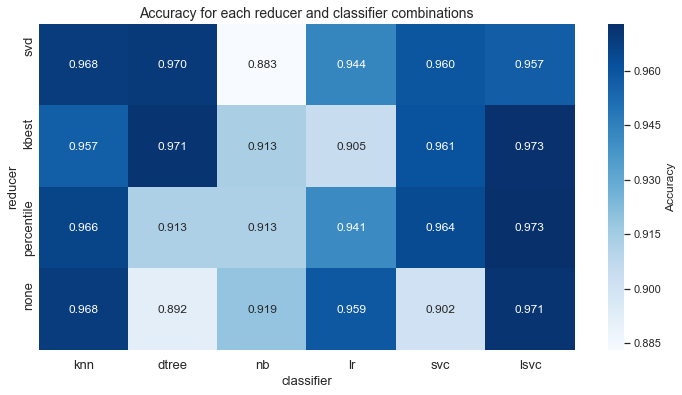

,reducer,classifier,precision,recall,f1-score,support
0,svd,knn,0.968425,0.968425,0.968425,2692
0,svd,dtree,0.956538,0.956538,0.956538,2692
0,svd,nb,0.966196,0.966196,0.966196,2692
0,svd,lr,0.968425,0.968425,0.968425,2692
0,svd,svc,0.969539,0.969539,0.969539,2692
0,svd,lsvc,0.971397,0.971397,0.971397,2692
0,kbest,knn,0.912704,0.912704,0.912704,2692
0,kbest,dtree,0.892273,0.892273,0.892273,2692
0,kbest,nb,0.882987,0.882987,0.882987,2692
0,kbest,lr,0.913447,0.913447,0.913447,2692


In [445]:
plot_heatmap(df_metrics_all, cols=['reducer', 'classifier', 'precision'], figsize=(12,6))
display(df_metrics_all.iloc[:,:-1])

# Part 2: Construction of a clustering of biology documents
We already know the class information in our dataset (positive and negative) but we will test if an automatic clustering system discovers automatically these classes (“labels”). The objective is to learn strategies that will be very useful when we have to cluster unlabeled documents. Therefore, we “hide” this information (the real class) to the clustering algorithm. 

The objective in this section is to check what are the parameters that maximize clustering’s quality. The parameters to be taken into account are:

- In function TfidfVectorizer:

    * Vocabulary (larger or smaller)
    * Norm (none, ‘l1’ or ‘l2’)
    
- In Latent Semantic Analysis (LSA):

    * n_components
    * o not performing LSA
    
- Normalize the data/not normalize it with “Normalizer” (included in the notebook).

The questions to be responded in this part are:

- Which tips can you give about constructing a text clustering with k-means? What do you recommend to do? What do you recommend not to do?

- What is the best clustering you have obtained? The quality of the cluster is the degree of correspondence between real class and assigned cluster. For example:

    * If there are 2 clusters and cluster 0 contains all examples of positive class and cluster 1 contains all examples of negative class, the clustering is perfect.
    * If there are 2 clusters and cluster 1 contains all examples of positive class and cluster 0 contains all examples of negative class, the clustering is also perfect.
    *  If there are 2 clusters and cluster 0 contains 50% of examples of positive class and 50% of examples of negative class, and statistics in cluster 1 are similar, the clustering quality is the worst possible.

## Strategy (tips)

We use of course *HGS* to compute the best parameters for k-means.

But first we transformed the prediction of k-means clustering as they come from a binary supervised classifier, by means of the following method:

```python
def get_prediction_from_cluster(X, pipeline):
    """ Transform cluster assignment in y_pred object"""
    def swap_label(label):
        if label == 1:
            return '0'
        elif label == 0:
            return '1'
        else:
            return str(label)
    labels = pipeline.predict(X_test)
    labels_predicted = [str(label) for label in labels]
    predicted = pd.Series(labels_predicted)
    accuracy = metrics.accuracy_score(y_test, predicted)
    labels_predicted_reverse = [swap_label(label) for label in labels]
    predicted_reverse = pd.Series(labels_predicted_reverse)
    accuracy_reverse = metrics.accuracy_score(y_test, predicted_reverse)
    if accuracy_reverse > accuracy: predicted = predicted_reverse
    return predicted
```

The basic idea is to compute the accuracy assigning arbitrarily the label 1 and 0 to one of the cluster, and then the reciprocal assignment. The choice is the one with the best computed accuracy. To do so, we compute k-means with two clusters, in order to simplify the binary class assignment.

With this strategy, we include k-means as a classifier in our previous pipeline.

**One note about the metrics**

In all this work we use the *micro avg* metrics from sklearn classification report: precision, recall, f1-score. But, for a binary classifier all three metrics are equal and equivalent to accuracy.

The heat map is computed for the precision metric.

## Best cluster

## Main process with prefixed parameters

In [422]:
param_ini = { 
    'vect__smooth_idf': True,
    'vect__sublinear_tf': True,
    'vect__max_features': 500,
    'vect__min_df': 1,
    'vect__max_df': 1.,
    'vect__stop_words': 'english',
    'vect__strip_accents' : 'unicode',
    'vect__analyzer' : 'word',
    'vect__ngram_range' : (1, 2),
    'vect__norm': 'l2',
    'red_svd__n_components': 10,
    'clf_knn__n_neighbors' : 2,
    'clf_kmeans__n_clusters' : 2,
    'red_kbest__k' : 3,
    'red_percentile__score_func' : f_classif,
    'red_percentile__percentile' : 10,
    'scaler': None
    #'scaler__with_mean' : False
}

reducers=REDUCERS
classifiers=['kmeans']
df_metrics_fixed_kmeans = process_classifications(X_train, y_train, X_test, y_test,\
                                                  param_ini, reducers=reducers, classifiers=classifiers)

### Reducer: svd   Classifier: kmeans
Accuracy 0.9320208023774146

### Reducer: kbest   Classifier: kmeans
Accuracy 0.7964338781575037

### Reducer: percentile   Classifier: kmeans
Accuracy 0.9071322436849926

### Reducer: none   Classifier: kmeans
Accuracy 0.9468796433878157



In [446]:
display(df_metrics_fixed_kmeans.iloc[:,:-1])

,reducer,classifier,precision,recall,f1-score,support
0,svd,kmeans,0.932021,0.932021,0.932021,2692
1,kbest,kmeans,0.796434,0.796434,0.796434,2692
2,percentile,kmeans,0.907132,0.907132,0.907132,2692
3,none,kmeans,0.946880,0.946880,0.946880,2692


## Main process with grid search parameters

In [398]:
eng_and_custom_stopwords = improve_stop_words(X_train, 200)
# First we adjust the vectorizer parameters
param_grid_vectorizer = { 
    'vect__norm': ['l1', 'l2', None],
    'vect__max_features': [500, 1000],
    'vect__min_df': [0.0],
    'vect__max_df': [1.],
    'vect__stop_words': [None, 'english', eng_and_custom_stopwords]
}

# Then we adjust the reducer parameters
param_grid_reducers = [
    {
         'red_svd__n_components' : [2, 3, 10, 30, 40, 100],
         'red_kbest__k' : [10, 20, 50],
         'red_percentile__score_func' : [f_classif],
         'red_percentile__percentile' : [5, 10]
    }
]

# Then we adjust the classifier parameters
param_grid_classifiers = [{
        'clf_kmeans__n_clusters' : [2]
    },
    {
        'clf_kmeans_norm': [None]
    }
]

df_metrics_all_kmeans = hyper_grid_search([param_grid_vectorizer, param_grid_reducers, param_grid_classifiers],\
                                          df_metrics_fixed_kmeans, reducers=reducers, classifiers=classifiers)

Stop words count: 449
Step 0 Reducer svd Classifier kmeans
### Reducer: svd   Classifier: kmeans

Best parameters
	clf_kmeans__n_clusters: 2
	red_svd__n_components: 10
	scaler: None
	vect__analyzer: 'word'
	vect__max_df: 1.0
	vect__max_features: 500
	vect__min_df: 0.0
	vect__ngram_range: (1, 2)
	vect__norm: 'l1'
	vect__smooth_idf: True
	vect__stop_words: None
	vect__strip_accents: 'unicode'
	vect__sublinear_tf: True

Accuracy 0.9446508172362555

Step 0 Reducer kbest Classifier kmeans
### Reducer: kbest   Classifier: kmeans

Best parameters
	clf_kmeans__n_clusters: 2
	red_kbest__k: 3
	scaler: None
	vect__analyzer: 'word'
	vect__max_df: 1.0
	vect__max_features: 500
	vect__min_df: 0.0
	vect__ngram_range: (1, 2)
	vect__norm: 'l2'
	vect__smooth_idf: True
	vect__stop_words: {'observed', 'what', 'first', 'reduced', 'con', 'disease', 'respectively', 'domain', 'where', 'all', 'seemed', 'wherein', 'front', 'seem', 'in', 'without', 'myself', 'while', 'her', 'related', 'acid', 'using', 'mill', 'he


Accuracy 0.5806092124814265

Step 1 Reducer percentile Classifier kmeans
### Reducer: percentile   Classifier: kmeans

Best parameters
	clf_kmeans__n_clusters: 2
	red_percentile__percentile: 10
	red_percentile__score_func: <function f_classif at 0x1a1db441e0>
	scaler: None
	vect__analyzer: 'word'
	vect__max_df: 1.0
	vect__max_features: 500
	vect__min_df: 0.0
	vect__ngram_range: (1, 2)
	vect__norm: 'l1'
	vect__smooth_idf: True
	vect__stop_words: None
	vect__strip_accents: 'unicode'
	vect__sublinear_tf: True

Accuracy 0.9446508172362555

Step 1 Reducer none Classifier kmeans
not affected
Step 2 Reducer svd Classifier kmeans
### Reducer: svd   Classifier: kmeans

Best parameters
	clf_kmeans__n_clusters: 2
	clf_kmeans_norm: None
	red_svd__n_components: 2
	scaler: None
	vect__analyzer: 'word'
	vect__max_df: 1.0
	vect__max_features: 500
	vect__min_df: 0.0
	vect__ngram_range: (1, 2)
	vect__norm: 'l1'
	vect__smooth_idf: True
	vect__stop_words: None
	vect__strip_accents: 'unicode'
	vect__subli

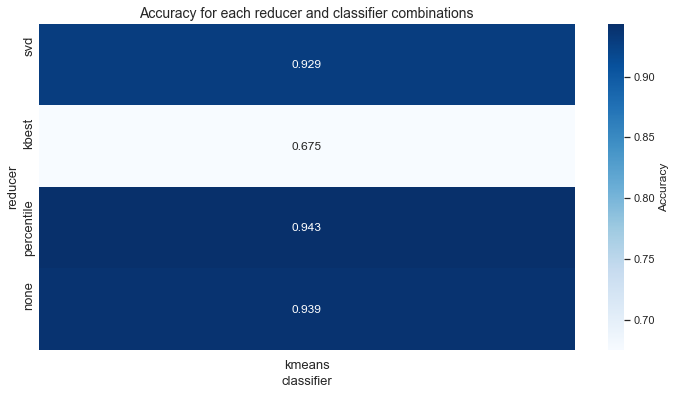

,reducer,classifier,precision,recall,f1-score,support
0,svd,kmeans,0.928678,0.928678,0.928678,2692
0,kbest,kmeans,0.674963,0.674963,0.674963,2692
0,percentile,kmeans,0.943165,0.943165,0.943165,2692
0,none,kmeans,0.939079,0.939079,0.939079,2692


In [447]:
plot_heatmap(df_metrics_all_kmeans, cols=['reducer', 'classifier', 'precision'], figsize=(12,6))
display(df_metrics_all_kmeans.iloc[:,:-1])

In [404]:
# Improve reducers
param_grid_reducers = [
    {
         'red_kbest__k' : [3, 5, 8, 10],
         'red_percentile__score_func' : [f_classif],
         'red_percentile__percentile' : [1, 2, 3]
    }
]

df_metrics_all_kmeans_2 = hyper_grid_search([param_grid_reducers], 
                                   df_metrics_all_kmeans, reducers=reducers, classifiers=classifiers)

Step 0 Reducer svd Classifier kmeans
not affected
Step 0 Reducer kbest Classifier kmeans
### Reducer: kbest   Classifier: kmeans

Best parameters
	clf_kmeans__n_clusters: 2
	clf_kmeans_norm: None
	red_kbest__k: 3
	scaler: None
	vect__analyzer: 'word'
	vect__max_df: 1.0
	vect__max_features: 500
	vect__min_df: 0.0
	vect__ngram_range: (1, 2)
	vect__norm: 'l2'
	vect__smooth_idf: True
	vect__stop_words: {'observed', 'what', 'first', 'reduced', 'con', 'disease', 'respectively', 'domain', 'where', 'all', 'seemed', 'wherein', 'front', 'seem', 'in', 'without', 'myself', 'while', 'her', 'related', 'acid', 'using', 'mill', 'here', 'type', 'twenty', 'already', 'may', 'when', 'will', 'response', 'until', 'transcription', 'mutant', 'development', 'moreover', 'effects', 'pathway', 'seems', 'everyone', 'can', 'every', 'around', 'other', 'factors', 'ever', 'per', 'show', 'on', 'none', 'couldnt', 'report', 'sometime', 'anyhow', 'throughout', 'again', 'upon', 'seeming', 'proteins', 'de', 'go', 'eight', '

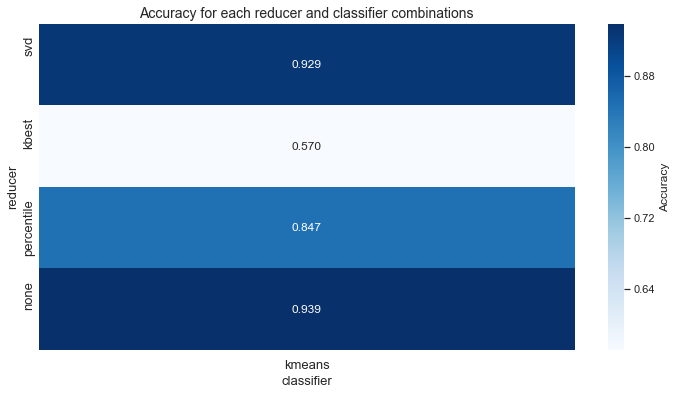

,reducer,classifier,precision,recall,f1-score,support
0,svd,kmeans,0.928678,0.928678,0.928678,2692
0,kbest,kmeans,0.570208,0.570208,0.570208,2692
0,percentile,kmeans,0.846954,0.846954,0.846954,2692
0,none,kmeans,0.939079,0.939079,0.939079,2692


In [448]:
plot_heatmap(df_metrics_all_kmeans_2, cols=['reducer', 'classifier', 'precision'], figsize=(12,6))
display(df_metrics_all_kmeans_2.iloc[:,:-1])

## Reference process

In [871]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

def get_X_transform(X):
    vectorizador = TfidfVectorizer(max_df=1., max_features=1000, norm='l2',
                                   min_df=1, stop_words='english',
                                   #stop_words=stopwords,
                                   #token_pattern=r'(?u)\b[A-Za-z]+\b',
                                   #token_pattern=r'(?ui)\b\w*[a-z]+\w*\b',
                                   use_idf=True)
    
    vectorizador = TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)
    
    X = vectorizador.fit_transform(X)

    print(X.shape)
    n_componentes = 100
    svd_truncado = TruncatedSVD(n_componentes)
    normalizador = Normalizer(copy=False)

    lsa = make_pipeline(svd_truncado, normalizador)
    #lsa = svd_truncado

    X_lsa = lsa.fit_transform(X)

    varianza_explicada = svd_truncado.explained_variance_ratio_.sum()
    normalizer = Normalizer()
    X_lsa_norm = normalizer.fit_transform(X_lsa)
    return X_lsa_norm

X_km = get_X_transform(X_train)
qmetric = calinski_harabaz_score

Nclusters_max = 15
Nrepetitions = 100

qualities = []
inertias = []
models = []
kini = 1
kfin = 20
for k in range(kini,kfin+1):
    print("Evaluando k=%d" % k)
    km = KMeans(n_clusters=k,
                init='k-means++', n_init=Nrepetitions,
                max_iter=500, random_state=2)    
    km.fit(X_km)
    models.append(km)
    inertias.append(km.inertia_)
    if k > 1:
        qualities.append(qmetric(X_km, km.labels_))
        #qualities.append(km.score(X_km))
    else:
        qualities.append(0)

(67, 1000)
Evaluando k=1
Evaluando k=2
Evaluando k=3
Evaluando k=4
Evaluando k=5
Evaluando k=6
Evaluando k=7
Evaluando k=8
Evaluando k=9
Evaluando k=10
Evaluando k=11
Evaluando k=12
Evaluando k=13
Evaluando k=14
Evaluando k=15
Evaluando k=16
Evaluando k=17
Evaluando k=18
Evaluando k=19
Evaluando k=20


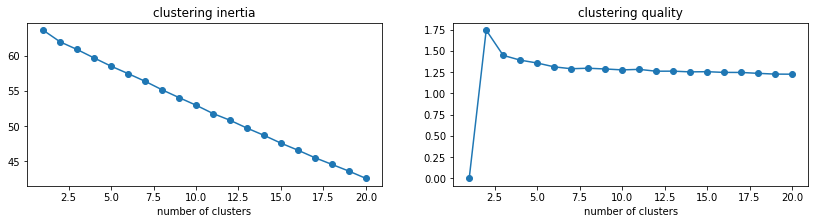

Best number of clusters 1
Number of clusters of best quality 2


In [872]:
fig = plt.figure(figsize=(14,3))

ax = plt.subplot(1,2,1)
plt.plot(range(kini,kfin+1), inertias, marker='o')
plt.xlabel('number of clusters')
plt.title('clustering inertia')

ax = plt.subplot(1,2,2)
plt.plot(range(kini,kfin+1), qualities, marker='o')
plt.xlabel('number of clusters')
plt.title('clustering quality')
plt.show()

best = pd.Series(qualities).idxmax() # get index for the best model
print("Best number of clusters", best)
km = models[best]
n_clusters = km.get_params()['n_clusters']
clusters = km.labels_
print ('Number of clusters of best quality', n_clusters)

In [873]:
# We choose the best option to evaluate the quality of prediction
X = X_test
y = y_test
X_km = get_X_transform(X)
labels = km.fit_predict(X_km)
#print(labels)
# First we try with labels as is 
labels_predicted = [str(label) for label in labels]
predicted = pd.Series(labels_predicted)
#print(labels_predicted)
print(metrics.classification_report(y, predicted))
print(metrics.confusion_matrix(y, predicted))

# Alternatively we invert the label to match the real labels of each group
labels_predicted = [str((label + 1)%2) for label in labels]
#print(labels_predicted)
predicted = pd.Series(labels_predicted)
print(metrics.classification_report(y, predicted))
print(metrics.confusion_matrix(y, predicted))

(33, 1000)
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       0.90      1.00      0.95        18

   micro avg       0.94      0.94      0.94        33
   macro avg       0.95      0.93      0.94        33
weighted avg       0.95      0.94      0.94        33

[[13  2]
 [ 0 18]]
              precision    recall  f1-score   support

           0       0.10      0.13      0.11        15
           1       0.00      0.00      0.00        18

   micro avg       0.06      0.06      0.06        33
   macro avg       0.05      0.07      0.06        33
weighted avg       0.05      0.06      0.05        33

[[ 2 13]
 [18  0]]


# Backups

In [ ]:
import pickle

copy = "1"
binary_file = open('df_metrics_all_' + copy + '.bin',mode='wb')
pickle.dump(df_metrics_all, binary_file)
binary_file.close()

# Outputs

In [482]:
%%bash
jupyter nbconvert --to=latex --template=~/report.tplx TextMining_Assignment.ipynb 1>/dev/null 2>/dev/null
/Library/TeX/texbin/pdflatex -shell-escape TextMining_Assignment 1>/dev/null 2>/dev/null
jupyter nbconvert --to html_toc TextMining_Assignment.ipynb 1>/dev/null 2>/dev/null